In [52]:
import netCDF4 as nc
import scipy.io as sio
import os,sys,fnmatch,time
from scipy import interpolate
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import cmocean as cmo

from salishsea_tools.nc_tools import scDataset
from salishsea_tools import geo_tools

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

(cmapmc, norm) = functions_plot.Colormap()
from matplotlib.colors import ListedColormap
cmapmc_r = ListedColormap(cmapmc.colors[::-1])
from matplotlib.colors import LinearSegmentedColormap
colour_list = ["#c8274c","#f25546","#F06543","#e96e33",
               "#f0b038","#FFE74C","#69b944","#72b286",
               "#69b0bc","#619ee4","#4b5bbb"][::-1]
cmapIAM = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

## Functions for model results

In [50]:
def get_vars(dirname, dep_start, dep_end, time_start, time_end):
    fname = "1_MCKNZ_1h_20170101_201701*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    dep_end = dep_end + 1
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
            
    with scDataset(filesT) as dsT:
        deptht = dsT.variables['deptht'][dep_start:dep_end]
        vosaline0 = dsT.variables['vosaline'][time_start:time_end, dep_start:dep_end, y, x]
        nav_lat = dsT.variables['nav_lat'][y, x]
        nav_lon = dsT.variables['nav_lon'][y, x]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, dep_start:dep_end, y, x]
        
    tmask = np.tile(tmask0, (len(vosaline0), 1, 1, 1))  
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    
    return vosaline, deptht, nav_lat, nav_lon

In [11]:
def get_vars_mean(dirname, dep_start, dep_end, time_start, time_end):
    vosaline, deptht, nav_lat, nav_lon = get_vars(dirname, dep_start, dep_end, time_start, time_end)
    vosaline_mean = np.mean(np.mean(vosaline, axis=0), axis=0)
    return vosaline_mean, deptht, nav_lat, nav_lon

## Functions for observations

In [12]:
data = sio.loadmat('./MackenzieTransects.mat')

struct_north = data['stn']
struct_south = data['sts']

dtype_north = struct_north.dtype
dtype_south = struct_south.dtype

data_north = {n: struct_north[n][0, 0] for n in dtype_north.names}
data_south = {n: struct_south[n][0, 0] for n in dtype_south.names}

lat_s = data_south['latx'][0,:]
lon_s = data_south['lonx'][0,:]
salt_s = ma.masked_invalid(data_south['sal'])
dep_s = data_south['z'][:,0]

lat_n = data_north['latx'][0,:]
lon_n = data_north['lonx'][0,:]
salt_n = ma.masked_invalid(data_north['sal'])
dep_n = data_north['z'][:,0]

In [13]:
def get_obs_mean(salt_s, salt_n, dep1, dep2):
    salt_mean_s = np.mean(salt_s[dep1:dep2, :], axis=0)
    salt_mean_n = np.mean(salt_n[dep1:dep2, :], axis=0)
    return salt_mean_s, salt_mean_n

## Figures comparing salinity mean at depths and times and observations

In [68]:
def plot_comparison(dirname, time_start, time_end, lon_s, lon_n, lat_s, lat_n, salt_s, salt_n, ttl):

    fig, axes = plt.subplots(2, 3, figsize=(20, 18), sharey=True, sharex=True)
    fig.tight_layout(h_pad=2.5, w_pad=0.02)
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    fig.suptitle('Salinity: model results ("'+ ttl+'" case) compared to observations', fontsize=25)

    depth_ind_starts = [2, 8, 15, 17, 20, 26]
    cmap = cmapIAM
    cmap.set_bad('silver')
    vmin, vmax = 32, 34.8

    for ax, depth_ind_start in zip(axes.flatten(), depth_ind_starts):
        dep_ind_end = depth_ind_start + 2
        vosaline_mean, deptht, nav_lat, nav_lon = get_vars_mean(dirname, depth_ind_start, dep_ind_end, time_start, time_end)

        dep_start, dep_end = int(deptht[0]), int(deptht[-1])
        salt_mean_s, salt_mean_n = get_obs_mean(salt_s, salt_n, dep_start, dep_end)

        vmin = min(np.min(vosaline_mean), np.min(salt_mean_s), np.min(salt_mean_n))
        vmax = max(np.max(vosaline_mean), np.max(salt_mean_s), np.max(salt_mean_n))

        p = ax.pcolormesh(nav_lon, nav_lat, vosaline_mean, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.scatter(lon_s, lat_s, c=salt_mean_s, s=100, edgecolors='k', cmap=cmap, vmin=vmin, vmax=vmax)
        ax.scatter(lon_n, lat_n, c=salt_mean_n, s=100, edgecolors='k', cmap=cmap, vmin=vmin, vmax=vmax)

        ax.set_title('depths ' + str(dep_start) + ' - ' + str(dep_end) 
                     + ' m\ntimes ' + str(time_start) + ' - ' + str(time_end) + ' hrs', fontsize=20)
        fig.colorbar(p, ax=ax, pad=0.025, orientation='horizontal')
        w=1/math.cos(math.radians(70.0))
        ax.set_aspect(w)
        ax.set_ylim([nav_lat.min(), nav_lat.max()])
        ax.set_xlim([nav_lon.min(), nav_lon.max()])
        
    return fig

In [69]:
time_start, time_end = 24*3, 24*4

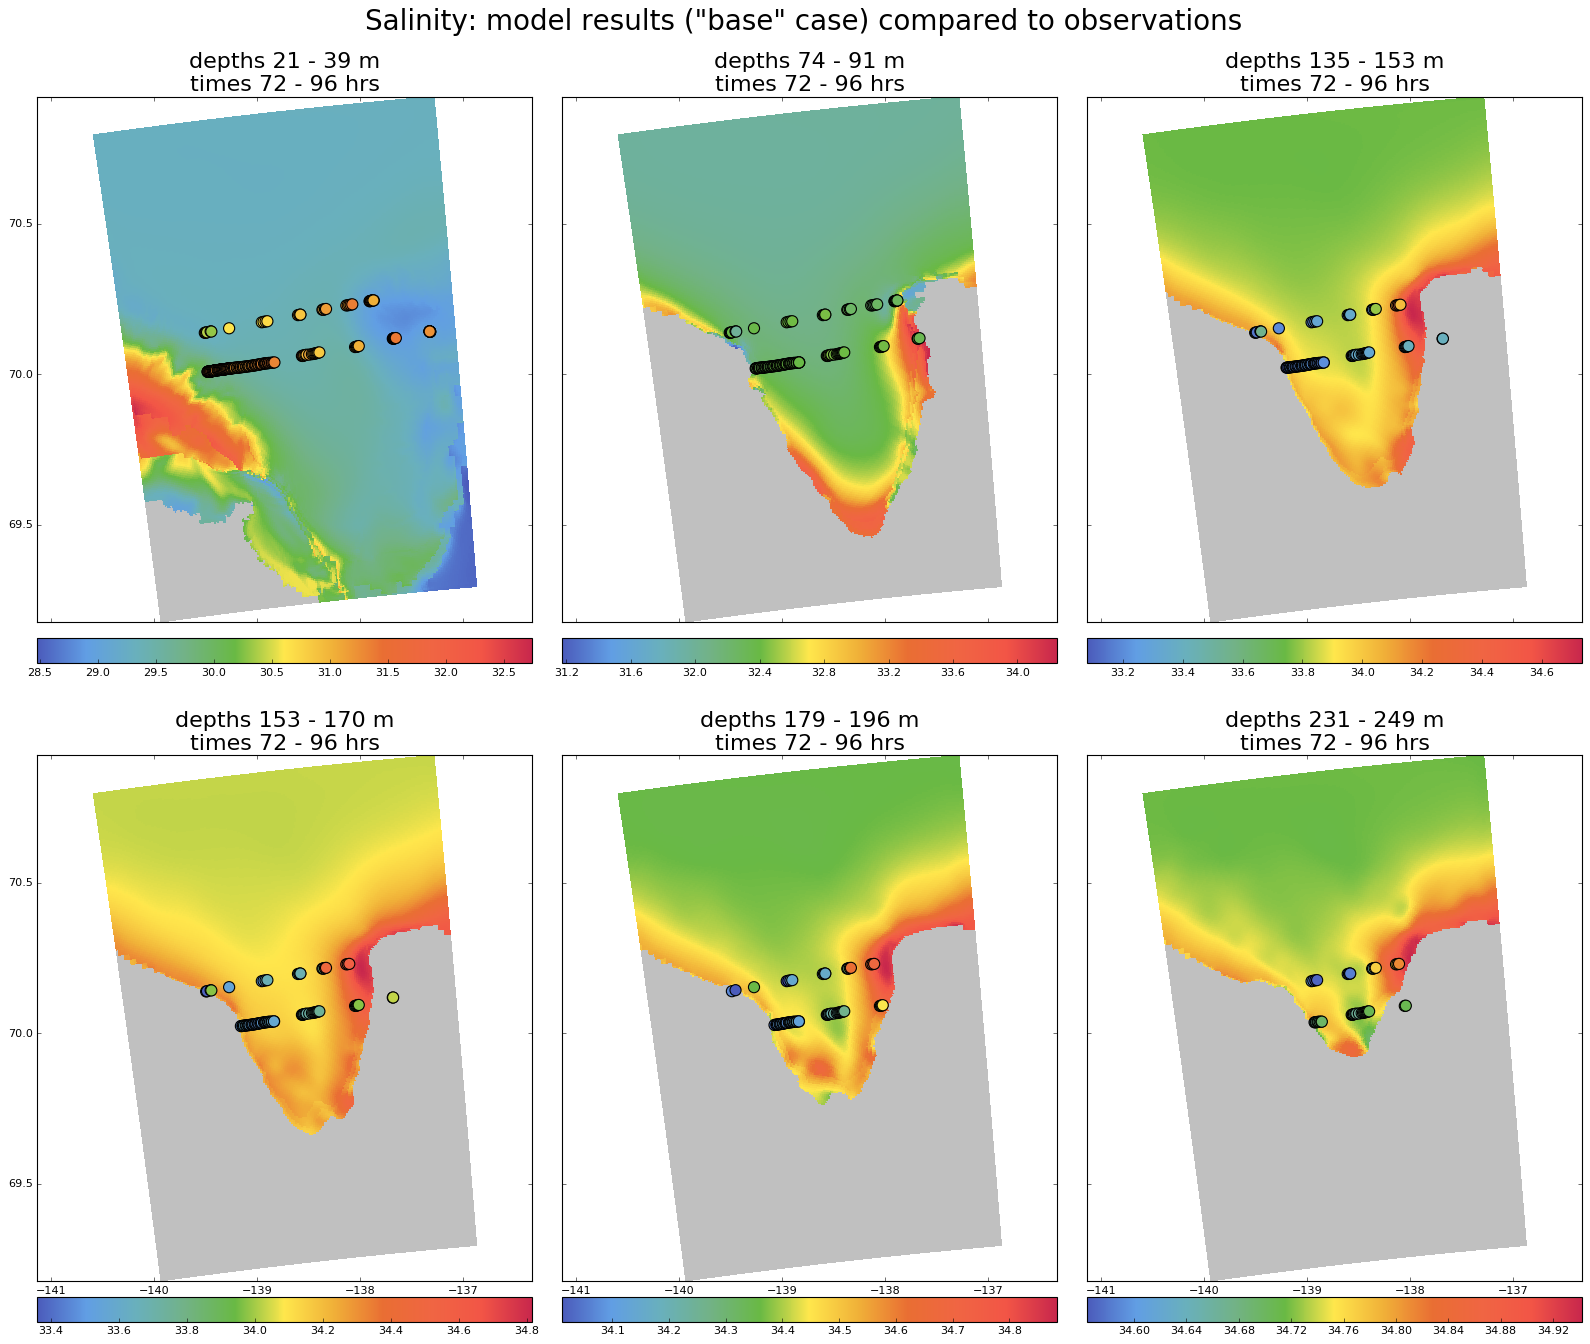

In [70]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/runs_with_ts/real_base/'
fig = plot_comparison(dirname, time_start, time_end, lon_s, lon_n, lat_s, lat_n, salt_s, salt_n, 'base')

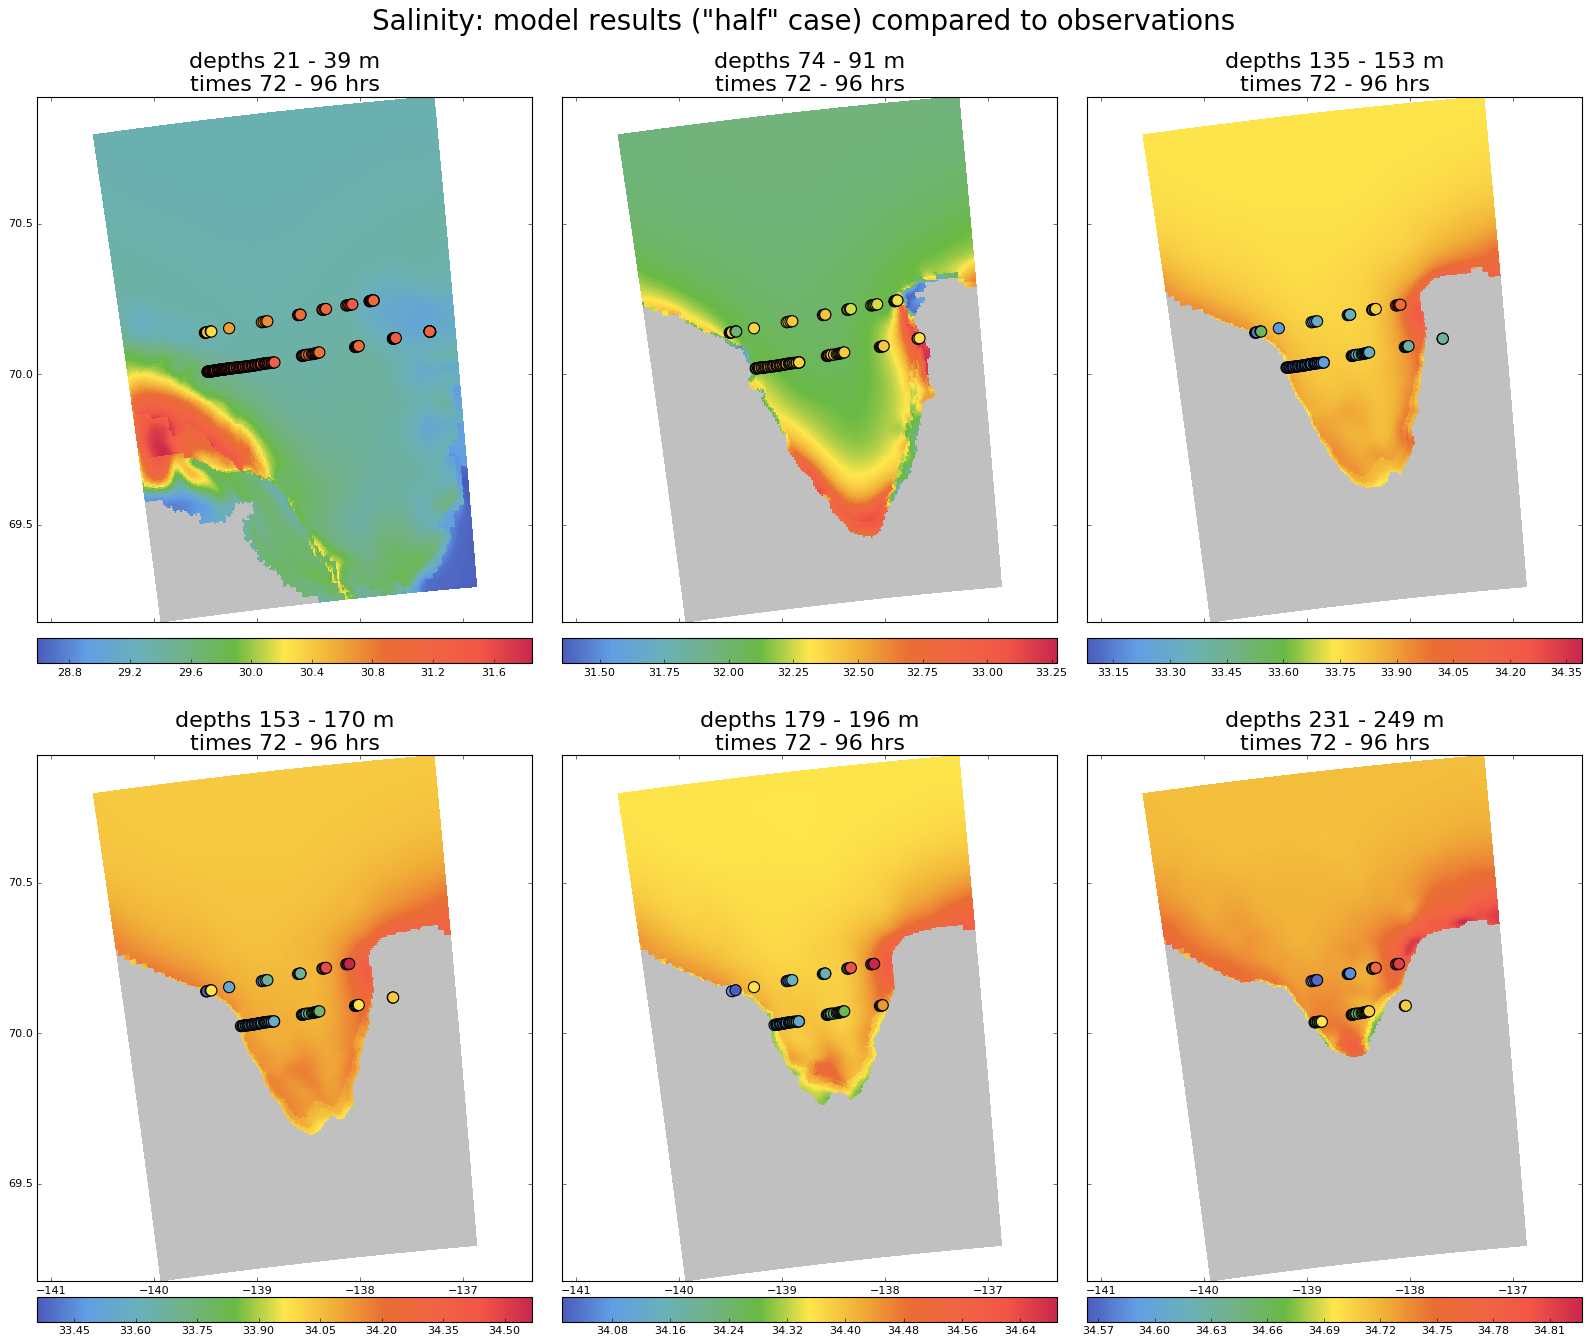

In [71]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/runs_with_ts/real_half/'
fig = plot_comparison(dirname, time_start, time_end, lon_s, lon_n, lat_s, lat_n, salt_s, salt_n, 'half')